In [1]:
# Import Torch
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Import Random
import random

# Import tqdm
from tqdm import tqdm

# Import Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

In [2]:
# checking for torch and torchvision versions
print(torch.__version__)
print(torchvision.__version__)

2.1.1+cu121
0.16.1+cu121


In [3]:
# Getting our MNIST Data 
train_root = "./FashonMNIST/train_data"
test_root = "./FashonMNIST/test_data"

train_data = datasets.FashionMNIST(root= train_root,
                                   train = True,
                                   transform = ToTensor(),
                                   target_transform = None,
                                   download = False)

test_data = datasets.FashionMNIST(root = test_root,
                                  train = False,
                                  transform = ToTensor(),
                                  target_transform = None,
                                  download = False)

In [4]:
class_names = train_data.classes

class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
len(train_data), len(test_data)

(60000, 10000)

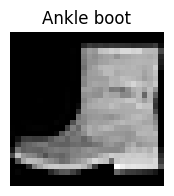

In [6]:
# setting the manual seed
torch.manual_seed(42)

# plot a random image from our dataset
plt.figure(figsize = (2, 2))
random_idx = torch.randint(0, len(train_data), size = [1]).item()


image, label = train_data[random_idx]

plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis("off")
plt.show()

In [7]:
# creating training and testing dataloaders 
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(dataset = train_data,
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                                num_workers = 4
                                                )

test_data_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               num_workers = 4)

Feature batch size : torch.Size([32, 1, 28, 28])
label batch size : torch.Size([32])


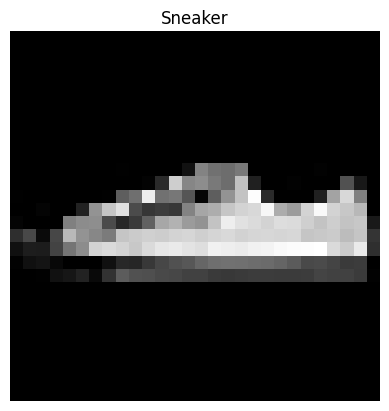

In [8]:
train_features, train_labels = next(iter(train_data_loader))

print(f"Feature batch size : {train_features.size()}")
print(f"label batch size : {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0].item()

plt.imshow(img, cmap = 'gray')
plt.axis("OFF")
plt.title(class_names[label])
plt.show()

In [9]:
img.unsqueeze(0).size()

torch.Size([1, 28, 28])

In [10]:
# creating a small model and test what is happening 
conv_layer = nn.Conv2d(in_channels=1, out_channels= 10, kernel_size= 3, stride = 1)
max_pool_layer = nn.MaxPool2d(kernel_size = 3)

out_conv_layer = conv_layer(img.unsqueeze(0))
out_max_pool_layer = max_pool_layer(out_conv_layer)


In [11]:
print(f"size before conv : {img.unsqueeze(0).size()}\n")
print(f"Size after Conv2D layer : {out_conv_layer.size()}\n")
print(f"Size after MaxPooling Layer : {out_max_pool_layer.size()}")

size before conv : torch.Size([1, 28, 28])

Size after Conv2D layer : torch.Size([10, 26, 26])

Size after MaxPooling Layer : torch.Size([10, 8, 8])


In [12]:
# making device agnostic code and sending our data to the available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
x_1, y_1 = next(iter(train_data_loader))

x_1.shape, y_1.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [57]:
# Functionalize Our evaluation method

def eval_model(model : torch.nn.Module,
               data_loader : DataLoader,
               loss_fnc : torch.nn.Module,
               accuracy_fn
               ):
    """ Returns a dictionary containing the results of model predicitons on data_loader """
    loss, accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            #Make predicitons
            y_preds = model(X)

            #Accumelate the loss and accuracy values per batch
            loss += loss_fnc(y_preds, y)
            accuracy += accuracy_fn(y, y_preds.argmax(dim = 1))
        # Scaling the loss and accuracy to find loss and accuracy per epoch
        loss /= len(data_loader)
        accuracy /= len(data_loader)
    return {"model_name" : model.__class__.__name__,
            "model_loss" : loss.item(),
            "model_accuracy" : accuracy}

In [14]:
# Building a Convolutional Neural Networks Model

class FashionMNISTModelv3(nn.Module):
    """Model architecture that replicates the TinyVGG
        model from CNN expainer website."""
    def __init__(self, inpute_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = inpute_shape,
                      out_channels = hidden_units,
                      kernel_size = (3,3), # length and hight of the filter
                      stride = 1, # the shift after every convolution operation
                      padding = 1 # pad the input image to keep the same dimension as output
                      ),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3,3), # length and hight of the filter
                      stride = 1, # the shift after every convolution operation
                      padding = 1 # pad the input image to keep the same dimension as output
                      ),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size = (3,3), # length and hight of the filter
                      stride = 1) # the shift after every convolution operation        
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3,3), # length and hight of the filter
                      stride = 1, # the shift after every convolution operation
                      padding = 1 # pad the input image to keep the same dimension as output
                      ),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3,3), # length and hight of the filter
                      stride = 1, # the shift after every convolution operation
                      padding = 1 # pad the input image to keep the same dimension as output
                      ),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size = (3,3), # length and hight of the filter
                      stride = 1) # the shift after every convolution operation        
            )
        
        # self.conv_block3 = nn.Sequential(
        #         nn.Conv2d(in_channels = hidden_units,
        #                 out_channels = hidden_units,
        #                 kernel_size = (3,3), # length and hight of the filter
        #                 stride = 1, # the shift after every convolution operation
        #                 padding = 1 # pad the input image to keep the same dimension as output
        #                 ),
        #         nn.ReLU(),

        #         nn.Conv2d(in_channels = hidden_units,
        #                 out_channels = hidden_units,
        #                 kernel_size = (3,3), # length and hight of the filter
        #                 stride = 1, # the shift after every convolution operation
        #                 padding = 1 # pad the input image to keep the same dimension as output
        #                 ),
        #         nn.ReLU(),

        #         nn.MaxPool2d(kernel_size = (3,3), # length and hight of the filter
        #                 stride = 1) # the shift after every convolution operation        
        #         )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 24 * 24,
                      out_features = output_shape),
            #nn.Softmax(dim = 1)
        )

    def forward(self, x : torch.tensor)-> torch.tensor:
        x = self.conv_block1(x)
        # print(f"shape of image after block1 : {x.shape}")
        x = self.conv_block2(x)
        # print(f"the shape of image after block2 : {x.shape}")
        # x = self.conv_block3(x)
        # print(f"shape of image after block3 : {x.shape}")
        x = self.classifier(x)
        # print(f"shape of image after classifier : {x.shape} ")
        return x


In [15]:
model_0 = FashionMNISTModelv3(inpute_shape = 1,
                              hidden_units = 10,
                              output_shape = 10)

model_0.to(device)

FashionMNISTModelv3(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5760, out_features=10, bias=True)
  )
)

In [16]:
random_image_tensor  = torch.randn([1, 28, 28])

In [17]:
model_0(random_image_tensor.unsqueeze(0).to(device))

tensor([[-0.0212,  0.0112, -0.0889,  0.0511, -0.0472, -0.0238,  0.0274, -0.0923,
          0.0481,  0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

## That's our model is working just fine now lets try to make a training loop and see weither the model is going to do well or not 

In [18]:
# Choosing loss function and optimzer
from helper_functions import accuracy_fn

loss_fnc = nn.CrossEntropyLoss()
optimzer = torch.optim.SGD(params = model_0.parameters(),
                           lr = 0.01)


In [19]:
def train_step(model:nn.Module,
               data_loader : DataLoader,
               loss_fnc : torch.nn.Module,
               optimzer : torch.optim.Optimizer,
               accuracy_fn,
               target_device :torch.device = device):
    """ Perform a training step with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    # Model train
    model.train()
    # Add a loop to loop through the training batches
    for X, y in data_loader:
        # Sending our data into the used device "GPU or CPU"
        X, y = X.to(target_device), y.to(target_device)
        # Do the forward Path
        y_pred = model(X)

        #calculate the loss
        loss = loss_fnc(y_pred, y)
        train_loss += loss

        #Calculating the training accuracy
        train_acc += accuracy_fn(y, y_pred.argmax(dim = 1))

        # optimzer zero grad
        optimzer.zero_grad()

        # loss backward
        loss.backward()

        # optimzer step
        optimzer.step()
    
    # Dividing total train loss and train accuracy by length of train dataloader to get training loss and training accuracy per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    # Print out what's happening 
    print(f"Train Loss : {train_loss:.2f} | Train accuracy : {train_acc:.2f}%")

In [20]:
def test_step(
             model : torch.nn.Module,
             data_loader : DataLoader,
             loss_fnc :torch.nn.Module,
             accuracy_fn,
             target_device : torch.device = device):
    """ Performs a testing loop step on model going over data_loader. """
    test_loss, test_acc = 0, 0
    # Put our model in evaluation mode 
    model.eval()
    # Turn on inference mode
    with torch.inference_mode():
        for X, y in tqdm(data_loader):

            # Send the data to the target device
            X, y = X.to(target_device), y.to(target_device)

            # 1. Do the forward Path
            test_pred = model(X)

            # 2. Calculate the loss and test accuracy
            test_loss += loss_fnc(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim = 1))
        # 3. Calculate the average loss and accuracy through the batch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        # 4. Printing out what's happening
        print(f"Test Loss : {test_loss:.4f} | Test accuracy : {test_acc:.2f}%\n")

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure our training time for our model 
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test Model
epochs = 4 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n --------")
    train_step(model = model_0,
               data_loader = train_data_loader,
               loss_fnc = loss_fnc,
               optimzer=optimzer,
               accuracy_fn = accuracy_fn,
               target_device = device
               )
    
    test_step(model = model_0,
              data_loader = test_data_loader,
              loss_fnc= loss_fnc,
              accuracy_fn= accuracy_fn,
              target_device= device
              )
train_time_end_model_2 = timer()
total_train_time = train_time_end_model_2 - train_time_start_model_2
print('-' * 50)
print(f"\nthe model took : {total_train_time:.2f} seconds to be trained\n")
    

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
 --------
Train Loss : 0.74 | Train accuracy : 72.99%


 25%|██▌       | 1/4 [00:18<00:55, 18.62s/it]

Test Loss : 0.4881 | Test accuracy : 82.51%

Epoch: 1
 --------
Train Loss : 0.43 | Train accuracy : 84.28%


 50%|█████     | 2/4 [00:34<00:34, 17.19s/it]

Test Loss : 0.4547 | Test accuracy : 82.60%

Epoch: 2
 --------
Train Loss : 0.38 | Train accuracy : 86.45%


 75%|███████▌  | 3/4 [00:52<00:17, 17.42s/it]

Test Loss : 0.3867 | Test accuracy : 86.42%

Epoch: 3
 --------
Train Loss : 0.35 | Train accuracy : 87.49%


100%|██████████| 4/4 [01:11<00:00, 17.99s/it]

Test Loss : 0.3480 | Test accuracy : 87.64%

--------------------------------------------------

the model took : 71.96 seconds to be trained



In [22]:
# Make and Evaluate random predictions

def make_predictions(model : torch.nn.Module,
                     data : list,
                     device : torch.device = device):
    pred_probs = []
    # Passing the model to the target device
    model.to(device)
    # Setting the model into inference mode
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # unsqueeze the sample to add a batch dimension and pass it to the target device
            sample = torch.unsqueeze(sample, dim = 0).to(device)

            # Forward path(model output raw logits)
            pred_logit = model(sample)

            # Going from raw logits to prediction probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

            # Get pred_prob off the GPU for further calculations 
            pred_probs.append(pred_prob.cpu())
            pred_labels = torch.stack(pred_probs).argmax(dim = 1)
    return pred_labels 

In [23]:
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

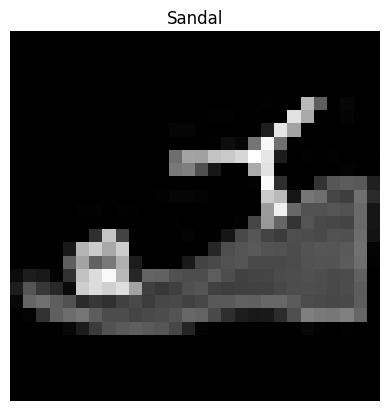

In [24]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])
plt.axis('off')
plt.show()

In [25]:
# Make some predictions to test our model 
pred_probs_tensor = make_predictions(model_0, test_samples)

In [26]:
test_labels

[5, 6, 0, 2, 1, 0, 6, 5, 4]

In [27]:
pred_probs_tensor

tensor([5, 0, 0, 2, 1, 2, 6, 5, 4])

In [28]:
len(pred_probs_tensor)

9

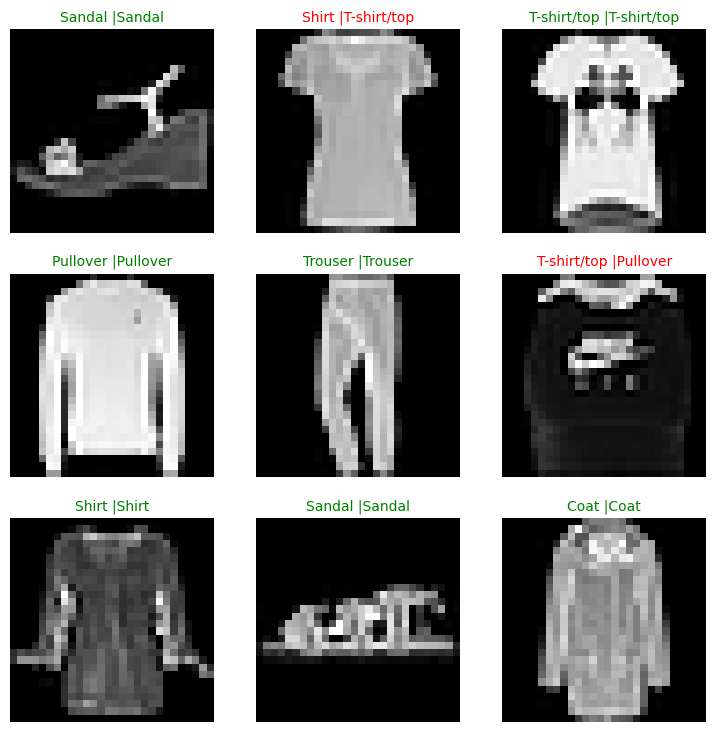

In [29]:
#plotting random samples of our data 
plt.figure(figsize=(9,9))
rows, colms = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(rows, colms, i + 1)
    pred_label = pred_probs_tensor[i]
    truth_label = test_labels[i]
    plt.imshow(sample.squeeze(), cmap = 'gray')
    title_text = f"{class_names[truth_label]} |{class_names[pred_label]}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize = 10, c = 'g')
    else:
        plt.title(title_text, fontsize = 10, c = 'r')
    plt.axis('off')

## plotting a confucsion matrix to see how are model is doing furtherly
- to plot a confusion matrix we need to 
1. Make predictions with our trained model on the entire test data
2. Make a confusion matrix using ` torchmetrics.ConfusionMatrix() `
3. Plot the Confusion matrix using ` mlxtend.plotting.plot_confusion_matrix()`

In [44]:
# set manual seed , cuda seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

batch_data_sample, label_sample = next(iter(test_data_loader))


batch_data_sample, label_sample = batch_data_sample.to(device), label_sample.to(device)

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(batch_data_sample)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1)

y_pred[:10]


tensor([3, 9, 7, 7, 3, 4, 6, 0, 4, 1], device='cuda:0')

In [45]:
label_sample[:10]

tensor([3, 9, 9, 7, 3, 2, 8, 0, 4, 1], device='cuda:0')

In [46]:
# 1. Make predictions with our trained model on the entire test data 
from tqdm.auto import tqdm

y_preds = []
y_true = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_data_loader, desc="Making Predictions...."):
        # Send the data into the target device
        X, y = X.to(device), y.to(device)
        # Forward Path 
        y_logits = model_0(X)
        # Turn prediction from logits -> prediction probabilties -> prediction labels
        y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1)
        # Put predictions on CPU
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())
# print(y_pred)
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

Making Predictions....: 100%|██████████| 313/313 [00:06<00:00, 45.69it/s] 


In [31]:
# See if Required packages are installed and if not, install them...
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version : {mlxtend.__version__}")
    assert int(mlxtend.__version__.split('.')[1] >= 19), "mlxtend version must be 0.19.0 or higher"
except:
    !pip install mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version : {mlxtend.__version__}")

mlxtend version : 0.23.1
mlxtend version : 0.23.1



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


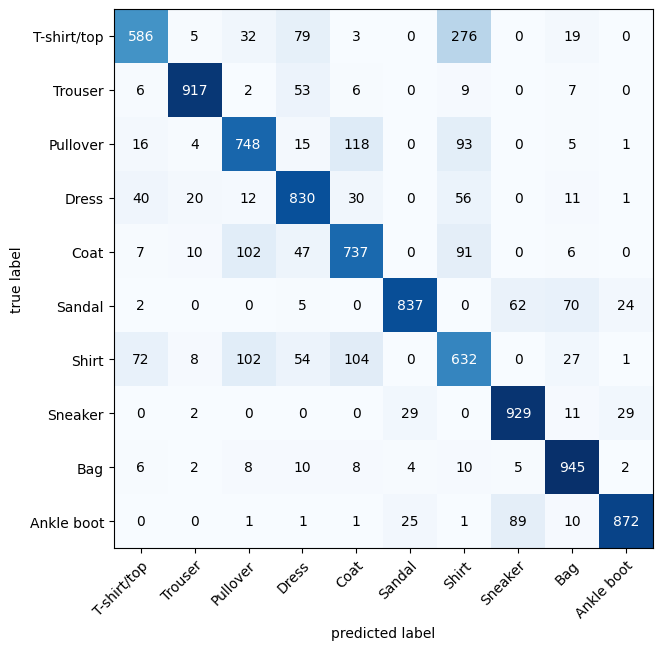

In [52]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#2. set up confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(task = 'multiclass',num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)

#3.plotting the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat= confmat_tensor.numpy(), # because of matplotlib we need to convert it to numpy
    class_names=class_names,
    figsize=(10, 7)
)

In [56]:
# save and load our model
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = '03_Pytorch_computer_vision_model_2.pth'

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# saving model state dict
print(f"saving model into :{MODEL_SAVE_PATH}")
torch.save(obj= model_0.state_dict(), f = MODEL_SAVE_PATH)

saving model into :Models\03_Pytorch_computer_vision_model_2.pth


In [59]:
# loading our model 
torch.manual_seed(42)


model_preloaded = FashionMNISTModelv3(inpute_shape=1,
                                      hidden_units=10,
                                      output_shape=10
                                      )

# loading the state dict where is saved inside the MODEL_SAVE_PATH
model_preloaded.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Evaluation our loaded model

model_preloaded_results = eval_model(model_preloaded,
                                     data_loader = test_data_loader,
                                     loss_fnc=loss_fnc,
                                     accuracy_fn= accuracy_fn)


model_preloaded_results

100%|██████████| 313/313 [00:11<00:00, 27.20it/s]


{'model_name': 'FashionMNISTModelv3',
 'model_loss': 0.3485640287399292,
 'model_accuracy': 87.60982428115015}

In [63]:
# comparing our loaded model to the original one 
model_0_result = eval_model(model_0.cpu(),
                            data_loader = test_data_loader,
                            loss_fnc=loss_fnc,
                            accuracy_fn= accuracy_fn)

model_0_result

100%|██████████| 313/313 [00:10<00:00, 29.70it/s]


{'model_name': 'FashionMNISTModelv3',
 'model_loss': 0.34870645403862,
 'model_accuracy': 87.60982428115015}

In [68]:
# check if models results are close to each other 
torch.isclose(torch.tensor(model_0_result['model_loss']),
              torch.tensor(model_preloaded_results['model_loss']),
              rtol = 1e-3)

tensor(True)